In [1]:
import os
import glob
import pathlib
import matplotlib_set_diagrams
import polars as pl
import numpy as np
import matplotlib.pylab as plt

from matplotlib.cbook import flatten
from matplotlib.axes import Axes
from typing import Any
from collections import OrderedDict, defaultdict

In [2]:
# If running with nbconvert 
WD = pathlib.Path(os.getcwd())
INTERACTIVE = WD.parts[-1] == "notebooks"
PATH_PREFIX = "../../" if INTERACTIVE else ""
OUTPUT_DIR = pathlib.Path(f"{PATH_PREFIX}results/nucflag_aligner_comparison").absolute()

CHROMS = [*[f"chr{i}" for i in range(1, 23)], "chrX", "chrY"]
ALIGNER_COLORS = ["#FF6666", "#66FF66", "#66B2FF"]
STATUS_COLORS = {
    "good": "blue",
    "misassembled": "orange"
}
ALIGNER_PARAMS = OrderedDict({
    "pbmm2": "pbmm2\n(-log-level DEBUG\n--preset SUBREAD\n--min-length 5000 -j 24)",
    "winnowmap": "winnowmap\n(-a --eqx --cs\n-x map-pb\n-t 24 -I8g)",
    "minimap2": "minimap2\n(-a --eqx --cs\n-x map-hifi\n-t 24 -I8g)"
})

In [3]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Runtime Benchmarks

In [4]:
bmk_rows = []
for bmk in glob.glob(f"{PATH_PREFIX}benchmarks/nucflag_*/align_*"):
    path = pathlib.Path(bmk)
    run_type = path.parts[3] if INTERACTIVE else path.parts[1]

    with open(path, "rt") as fh:
        next(fh)
        for line in fh.readlines():
            wall_time, _, rss, *_, cpu_time = line.strip().split()
            bmk_rows.append((run_type, path.parts[-1], wall_time, cpu_time, rss))

df_bmk = (
    pl.DataFrame(
        bmk_rows,
        schema={
            "aligner": pl.String,
            "reads_file": pl.String,
            "wall_time": pl.Float32,
            "cpu_time": pl.Float32,
            "rss": pl.Float32
        }
    )
    .with_columns(
        pl.col("aligner").str.replace("nucflag_", "", literal=True).cast(pl.Enum(ALIGNER_PARAMS.keys())),
        pl.col("reads_file").str.extract(r"^align_(.*?)_hifi_reads_to_asm.tsv"),
        pl.col("cpu_time") / 3600,
        pl.col("wall_time") / 3600,
        pl.col("rss") / 1000
    )
)
df_bmk

aligner,reads_file,wall_time,cpu_time,rss
enum,str,f32,f32,f32
"""pbmm2""","""HG01884_HG01884.m54329U_210713…",1.251153,28.678995,90.396286
"""pbmm2""","""HG00609_m84081_231124_021221_s…",1.409482,32.875549,132.907135
"""pbmm2""","""HG01884_m84046_230707_192442_s…",0.418759,9.375425,105.31498
"""pbmm2""","""HG00423_m84081_231112_030942_s…",0.963935,19.23654,130.623184
"""pbmm2""","""HG00544_m84081_231119_032407_s…",1.344057,27.926069,130.272659
…,…,…,…,…
"""minimap2""","""HG01346_HG01346.m64076_210621_…",0.545695,11.189831,83.087303
"""minimap2""","""HG01099_m84081_231124_024327_s…",0.411005,7.472739,61.803291
"""minimap2""","""HG01884_HG01884.m54329U_210716…",0.531145,10.661254,80.56839


In [5]:
def draw_boxplots(df: pl.DataFrame, col: str, title: str, ylabel: str, *, sharey: bool = True, xlabels: dict[str, str] | None = None) -> tuple[plt.Figure, Any]:
    fig, axs = plt.subplots(1, 3, figsize=(8, 6), sharey=sharey)
    fig.suptitle(title)
    fig.supylabel(ylabel)
    fig.tight_layout()
    
    xlabels = xlabels if xlabels else {}

    for ax, (categ, df_categ), color in zip(axs, df.group_by(["aligner"], maintain_order=True), ALIGNER_COLORS):
        categ = categ[0]
        ax: Axes

        bplot = ax.boxplot(df_categ[col], manage_ticks=True, patch_artist=True)
        for patch in bplot["boxes"]:
            patch.set_facecolor(color)
        ax.set_xlabel(xlabels.get(categ, categ))
        ax.set_xticks([])

        quantiles = (df_categ[col].quantile(q) for q in [0.25, 0.5, 0.75])
        for q in quantiles:
            y = q
            ax.annotate(
                '%.2f' % q,
                (1, y),
                xytext=(1-0.1, y),
                textcoords='data',
                va='center',
                ha='right'
            )
    
    return fig, axs


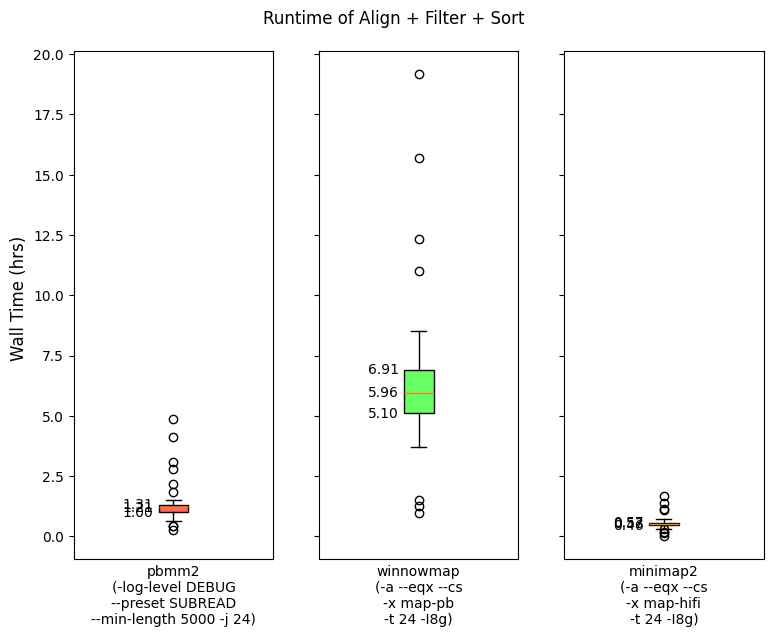

In [6]:
plt.close("all")
fig_wall_time, _ = draw_boxplots(df_bmk, "wall_time", "Runtime of Align + Filter + Sort", "Wall Time (hrs)", xlabels=ALIGNER_PARAMS)
fig_wall_time.savefig(OUTPUT_DIR.joinpath("wall_time.png"))
fig_wall_time.show()

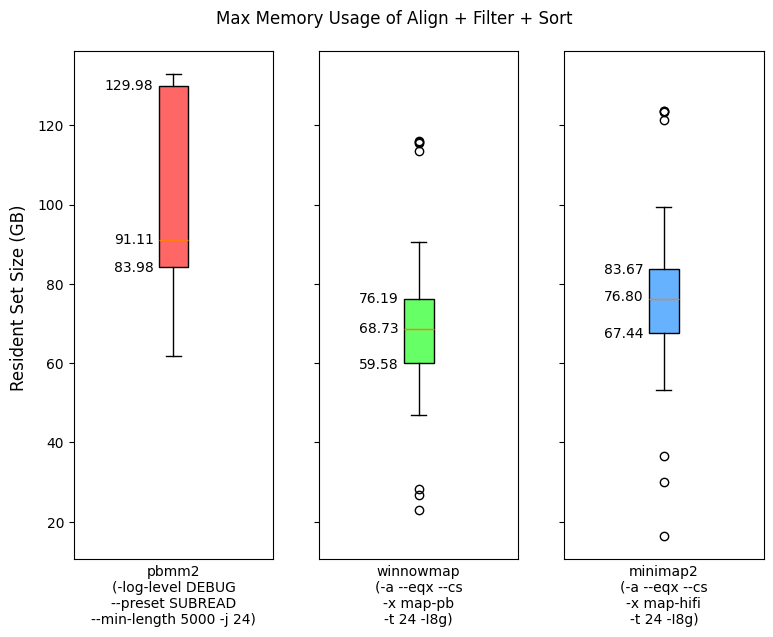

In [7]:
plt.close("all")
fig_memory, _ = draw_boxplots(df_bmk, "rss", "Max Memory Usage of Align + Filter + Sort", "Resident Set Size (GB)", xlabels=ALIGNER_PARAMS)
fig_memory.savefig(OUTPUT_DIR.joinpath("memory_usage.png"))
fig_memory.show()

# Number of Centromeres Correct

In [8]:
df_all_status_long = pl.concat(
    pl.read_csv(
        f"{PATH_PREFIX}results/nucflag_{aligner_name}/*_cen_status.bed",
        separator="\t",
        has_header=False,
        new_columns=["ctg", "start", "stop", "status"],
        glob=True
    )
    .with_columns(
        aligner=pl.lit(aligner_name),
        chrom=pl.col("ctg").str.extract(r"_(rc-)*(chr\w*?)_", group_index=2),
        sample=pl.col("ctg").str.extract(r"(\w*?)_"),
    )
    .with_columns(
        pl.col("aligner").cast(pl.Enum(ALIGNER_PARAMS.keys())),
        pl.col("chrom").cast(pl.Enum(CHROMS))
    )
    for aligner_name in ALIGNER_PARAMS.keys()
)
df_all_status_long

ctg,start,stop,status,aligner,chrom,sample
str,i64,i64,str,enum,enum,str
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""good""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""misassembled""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""good""","""pbmm2""","""chr16""","""HG00423"""
…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""misassembled""","""minimap2""","""chr5""","""HG01884"""


In [9]:
df_all_status_wide = df_all_status_long.pivot(index=["ctg", "start", "stop", "chrom", "sample"], columns="aligner", values="status")
df_all_status_wide

ctg,start,stop,chrom,sample,pbmm2,winnowmap,minimap2
str,i64,i64,enum,str,str,str,str
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""chr11""","""HG00423""","""good""","""good""","""good"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""chr11""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""good"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""chr16""","""HG00423""","""good""","""good""","""good"""
…,…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""chr5""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""


In [10]:
df_all_status_combined = (
    df_all_status_wide
    .select("chrom", "pbmm2", "winnowmap", "minimap2")
    .with_columns(pl.col("pbmm2", "winnowmap", "minimap2").replace({"good": 1, "misassembled": 0}))
    .select("chrom", comb=pl.col("pbmm2") + pl.col("winnowmap") + pl.col("minimap2"))
)
df_all_status_combined

chrom,comb
enum,str
"""chr11""","""111"""
"""chr11""","""000"""
"""chr12""","""001"""
"""chr12""","""000"""
"""chr16""","""111"""
…,…
"""chr4""","""000"""
"""chr4""","""000"""
"""chr5""","""000"""


In [11]:
df_all_status_grouped_combined = df_all_status_combined.group_by("chrom").agg(pl.col("comb").value_counts()).sort(by="chrom")
df_all_status_grouped_combined

chrom,comb
enum,list[struct[2]]
"""chr1""","[{""000"",16}, {""101"",2}, {""111"",2}]"
"""chr2""","[{""000"",9}, {""111"",9}, {""101"",2}]"
"""chr3""","[{""000"",10}, {""111"",6}, … {""101"",1}]"
"""chr4""","[{""000"",10}, {""111"",9}]"
"""chr5""","[{""000"",17}, {""111"",2}, {""110"",1}]"
…,…
"""chr20""","[{""000"",14}, {""100"",1}, … {""001"",1}]"
"""chr21""","[{""111"",13}, {""000"",6}]"
"""chr22""","[{""111"",7}, {""101"",3}, … {""001"",1}]"


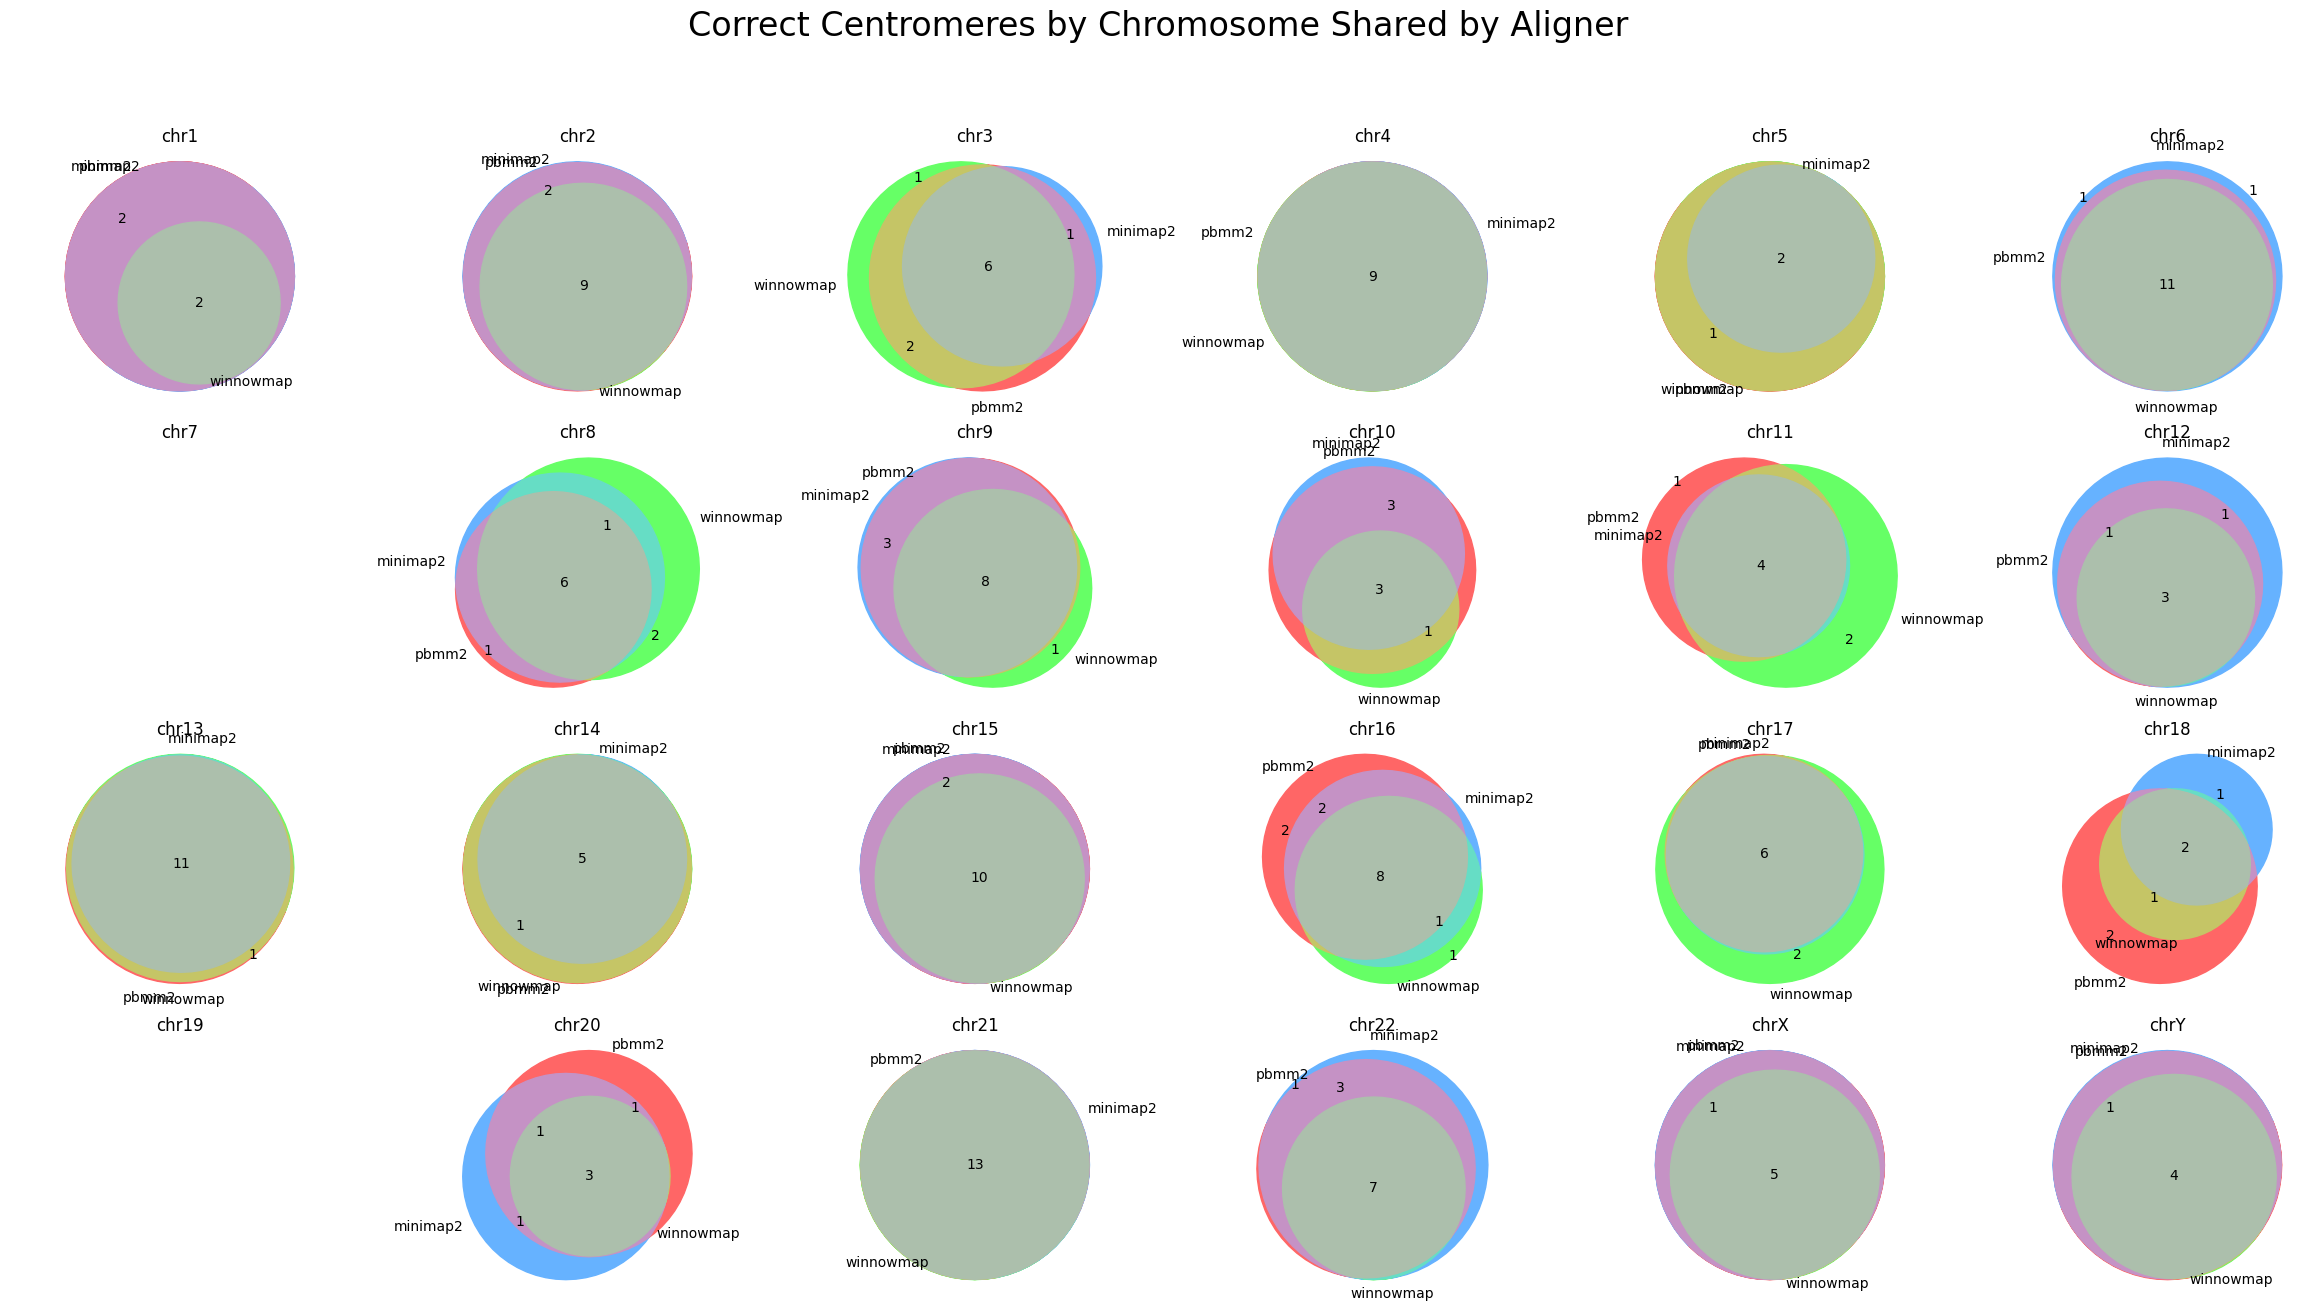

In [12]:
plt.close("all")
fig, axes = plt.subplots(
    nrows=4, ncols=6, figsize=(24, 12),
)
fig.tight_layout()
fig.suptitle("Correct Centromeres by Chromosome Shared by Aligner ", fontsize=24, y=1.10)

all_comb_cnts = defaultdict(int)
for ax, (chrom_name, comb_cnt_list) in zip(flatten(axes), df_all_status_grouped_combined.iter_rows()):
    ax: plt.Axes
    comb_cnts = {}
    for comb in comb_cnt_list:
        comb_vals = comb.values()
        subset, size = comb_vals
        subset = tuple(int(i) for i in subset)
        if subset == (0, 0, 0):
            continue

        comb_cnts[subset] = size
        all_comb_cnts[subset] += size
    
    ax.set_title(chrom_name)

    if not comb_cnts:
        ax.axis("off")
        continue

    matplotlib_set_diagrams.EulerDiagram(
        comb_cnts,
        set_labels=ALIGNER_PARAMS.keys(),
        set_colors=ALIGNER_COLORS,
        cost_function_objective="squared",
        ax=ax
    )

plt.savefig(OUTPUT_DIR.joinpath("venn_shared_correct_cens_by_chrom.png"))

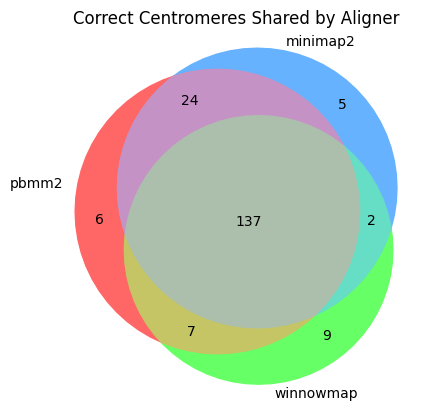

In [13]:
plt.close("all")
ax = plt.gca()
matplotlib_set_diagrams.EulerDiagram(
    all_comb_cnts,
    set_labels=ALIGNER_PARAMS.keys(),
    set_colors=ALIGNER_COLORS,
    cost_function_objective="squared",
    ax=ax
)
_ = ax.set_title("Correct Centromeres Shared by Aligner")
plt.savefig(OUTPUT_DIR.joinpath("venn_shared_correct_cens.png"))


In [14]:
df_all_status_long_summarized_chr = (
    df_all_status_long.group_by("aligner", "chrom")
    .agg(pl.col("status").value_counts())
    .explode("status")
    .unnest("status")
    .sort("chrom", "aligner", "status")
)
df_all_status_long_summarized_chr

aligner,chrom,status,count
enum,enum,str,u32
"""pbmm2""","""chr1""","""good""",4
"""pbmm2""","""chr1""","""misassembled""",16
"""winnowmap""","""chr1""","""good""",2
"""winnowmap""","""chr1""","""misassembled""",18
"""minimap2""","""chr1""","""good""",4
…,…,…,…
"""minimap2""","""chrX""","""misassembled""",9
"""pbmm2""","""chrY""","""good""",5
"""winnowmap""","""chrY""","""good""",4


In [15]:
df_all_status_long_summarized = df_all_status_long.group_by("aligner").agg(pl.col("status").value_counts()).explode("status").unnest("status")
df_all_status_long_summarized

aligner,status,count
enum,str,u32
"""pbmm2""","""good""",174
"""pbmm2""","""misassembled""",275
"""winnowmap""","""good""",155
"""winnowmap""","""misassembled""",294
"""minimap2""","""misassembled""",281
"""minimap2""","""good""",168


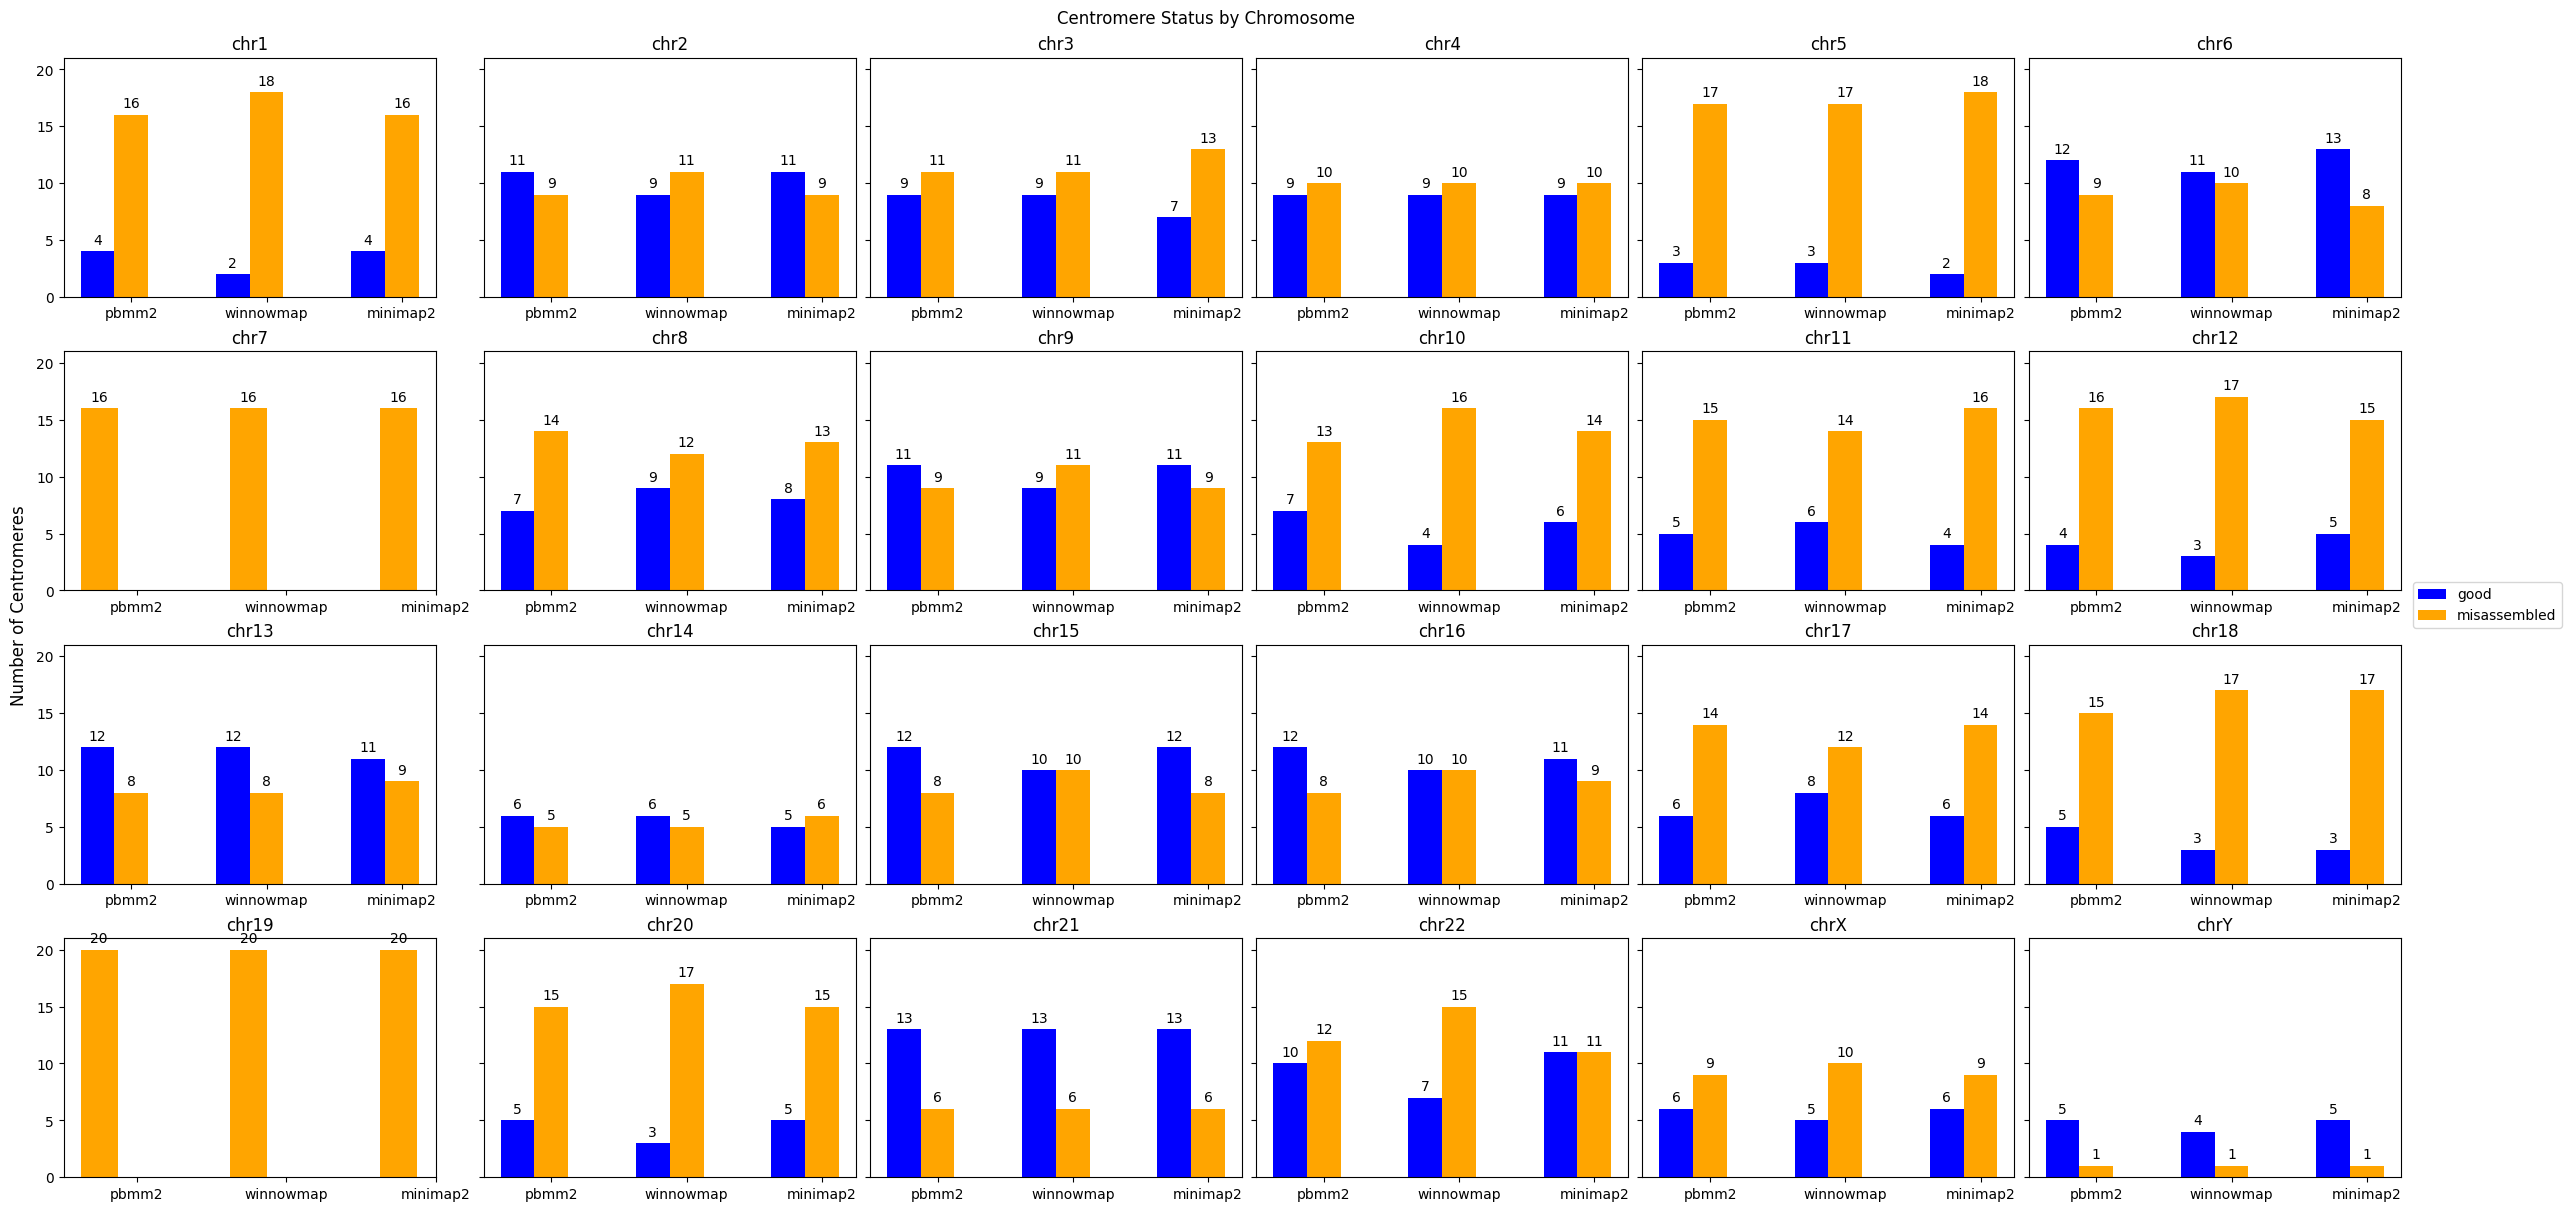

In [16]:
plt.close("all")
fig, axes = plt.subplots(4, 6, layout='constrained', figsize=(24, 12), sharey=True)
width = 0.25

for i, (chrom_name, df_chrom) in enumerate(df_all_status_long_summarized_chr.group_by(["chrom"], maintain_order=True)):
    row, col = divmod(i, 6)
    ax: plt.Axes = axes[row, col]
    chrom_name = chrom_name[0]
    x = np.arange(len(ALIGNER_PARAMS.keys()))
    for i2, (status, df_status_grp) in enumerate(df_chrom.group_by(["status"], maintain_order=True)):
        status = status[0]
        color = STATUS_COLORS[status]
        offset = width * i2
        rects = ax.bar(x + offset, df_status_grp["count"], width, label=status, color=color)
        ax.bar_label(rects, padding=3)
        ax.set_title(chrom_name)
        ax.set_xticks(x + width, ALIGNER_PARAMS.keys())

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.supylabel("Number of Centromeres")
fig.suptitle('Centromere Status by Chromosome')
_ = fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(OUTPUT_DIR.joinpath("cens_status_by_chrom.png"))

    

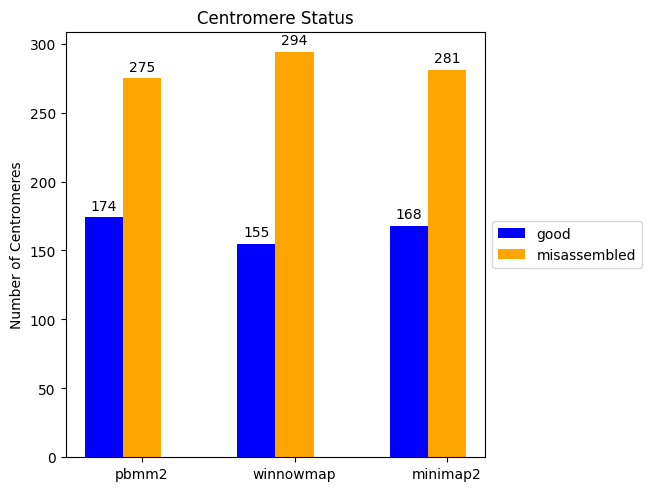

In [17]:
plt.close("all")
fig, ax = plt.subplots(layout='constrained')
ax: plt.Axes
width = 0.25

x = np.arange(len(ALIGNER_PARAMS.keys()))
for i, (status, df_status_grp) in enumerate(df_all_status_long_summarized.group_by(["status"], maintain_order=True)):
    status = status[0]
    color = STATUS_COLORS[status]
    offset = width * i
    rects = ax.bar(x + offset, df_status_grp["count"], width, label=status, color=color)
    ax.bar_label(rects, padding=3)

ax.set_ylabel('Number of Centromeres')
ax.set_title('Centromere Status')
ax.set_xticks(x + width, ALIGNER_PARAMS.keys())
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(OUTPUT_DIR.joinpath("cens_status.png"))

# Interesting differences
* HG00423_rc-chr15_pat-0000507:7304444-13860443.png
* HG00423_rc-chr10_mat-0000030:38571345-42825894
* HG00423_chr5_pat-0000495:45646463-53743265.png